$$\Huge \text{RAPORT}$$
$$\huge \text{LISTA 3}$$
$$\large \text{Autorzy: Katarzyna Rudzińska, Jagoda Płócienniczak}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import binomtest, chi2, norm

Analiza składa się z pięciu głównych części, z których niektóre odwołują się do wcześniej wprowadzonych pojęć i zmiennych z poprzedniego raportu. Aby zachować spójność oraz umożliwić pełne zrozumienie, ich implementacja została powtórzona również w tym opracowaniu. W ten sposób raport pozostaje spójny i czytelny.

In [2]:
data = pd.read_csv('ankieta.csv', encoding='Windows-1250', sep=';')
data['DZIAŁ'] = data['DZIAŁ'].astype("category")
data['CZY_KIER'] = data['CZY_KIER'].astype("category")
data['PŁEĆ'] = data['PŁEĆ'].astype("category")

In [3]:
def is_satisfied(satisfaction_lvl):
    if satisfaction_lvl == -2 or satisfaction_lvl == -1:
        return 'NIE'
    else:
        return 'TAK'

data["CZY_ZADOW"] = data["PYT_2"].apply(is_satisfied)
data["CZY_ZADOW"] = data["CZY_ZADOW"].astype("category")

In [4]:
data["CZY_ZADOW_2"] = data["PYT_3"].apply(is_satisfied)
data["CZY_ZADOW_2"] = data["CZY_ZADOW_2"].astype("category")

czy_zadow = data["CZY_ZADOW"].apply(lambda x: 1 if x == "TAK" else 0).astype(int)
czy_zadow_2 = data["CZY_ZADOW_2"].apply(lambda x: 1 if x == "TAK" else 0).astype(int)

## CZĘŚĆ I i II

### ZADANIE 1
    Napisz funkcję, która zwraca p-wartość w omówionym na wykładzie warunkowym teście symetrii w przypadku tabeli 2×2.

In [2]:
def warunkowy_test_symetrii(b, c):
    """
    Warunkowy test symetrii dla tabeli 2x2 oparty na rozkładzie dwumianowym B(n*, 1/2)

    Parametry:
    b -- liczba przypadków A=1, B=2 (Y_12)
    c -- liczba przypadków A=2, B=1 (Y_21)

    Zwraca:
    p-wartość testu
    """
    n_star = b + c
    if n_star == 0:
        return 1.0  # Brak danych do testu, przypadki symetryczne
    wynik = binomtest(b, n=n_star, p=0.5, alternative='two-sided')
    return wynik.pvalue


Funkcja `warunkowy_test_symetrii(b, c)` implementuje dokładny test warunkowy służący do sprawdzania **symetrii** w tabeli 2×2, czyli testowania hipotezy:

$
H_0 : p_{12} = p_{21}
$

Dla tabeli:

|       | B=1       | B=2       |
|-------|-----------|-----------|
| A=1   | $ Y_{11} $ | $ Y_{12} $ |
| A=2   | $ Y_{21} $ | $ Y_{22} $ |

test koncentruje się na wartościach poza przekątną:  
$ Y_{12} = b $, $ Y_{21} = c $

Zakładając hipotezę zerową $ H_0 $, statystyka $ Y_{12} $ warunkowana sumą $ Y_{12} + Y_{21} = n^* $ ma rozkład:

$
Y_{12} \mid (Y_{12} + Y_{21} = n^*) \sim \text{B}(n^*, 0.5)
$

gdzie:
- $ n^* = b + c $ — łączna liczba przypadków niesymetrycznych,
- $ \text{B}(n^*, 0.5) $ — rozkład dwumianowy z parametrem sukcesu \( p = 0.5 \)

Funkcja zwraca dokładną **p-wartość** testu dwustronnego na podstawie tego rozkładu. Jest to test **dokładny**, zalecany przy małych licznościach.


In [3]:
p = warunkowy_test_symetrii(b=3, c=7)
print("P-wartość:", p)

P-wartość: 0.34375


### ZADANIE 2
    W tabeli 1 umieszczono dane dotyczące reakcji na lek po godzinie od jego przyjęcia dla dwóch różnych leków przeciwbólowych stosowanych w migrenie. Leki zostały zaaplikowane grupie pacjentów w dwóch różnych atakach bólowych. Na podstawie danych zweryfikuj hipotezę, że leki te są jednakowo skuteczne korzystając z testu:

        a) McNemara z poprawką na ciągłość,
        b) warunkowego (korzystając z funkcji zadeklarowanej w zadaniu 1.) 

<div align="center">

<table>
  <thead>
    <tr>
      <th rowspan="2">Reakcja na lek A</th>
      <th colspan="2">Reakcja na lek B</th>
    </tr>
    <tr>
      <th>Negatywna</th>
      <th>Pozytywna</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Negatywna</strong></td>
      <td>1</td>
      <td>5</td>
    </tr>
    <tr>
      <td><strong>Pozytywna</strong></td>
      <td>2</td>
      <td>4</td>
    </tr>
  </tbody>
</table>

<br>
Table 1: Dane do zadania 2.


Na podstawie danych zawartych w **Tabeli 1**, testujemy hipotezę:

$
H_0: \text{Skuteczność leku A i leku B jest taka sama}
$

Dane przedstawiają sparowaną tablicę 2×2:

|                        | Lek B: Negatywna | Lek B: Pozytywna |
|------------------------|------------------|------------------|
| **Lek A: Negatywna**   | $ a = 1 $       | $ b = 5 $      |
| **Lek A: Pozytywna**   | $ c = 2 $       | $ d = 4 $       |

Zatem mamy:
- $ b = 5 $: A negatywna, B pozytywna  
- $ c = 2 $: A pozytywna, B negatywna

#### a) Test McNemara z poprawką na ciągłość

Test McNemara dla tabeli 2×2 z poprawką na ciągłość obliczany jest ze wzoru:

$
\chi^2 = \frac{(|b - c| - 1)^2}{b + c}
$

Wartość statystyki testowej porównujemy z rozkładem chi-kwadrat z 1 stopniem swobody.

In [7]:
b = 5
c = 2

chi2_stat = ((abs(b - c) - 1) ** 2) / (b + c)
p_mcnemar = 1 - chi2.cdf(chi2_stat, df=1)

print("Test McNemara:")
print("Statystyka chi^2:", chi2_stat)
print("P-wartość:", p_mcnemar)

Test McNemara:
Statystyka chi^2: 0.5714285714285714
P-wartość: 0.4496917979688908


#### b) Warunkowy test symetrii 

In [8]:
p_warunkowy = warunkowy_test_symetrii(b=5, c=2)

print("Warunkowy test symetrii:")
print("P-wartość:", p_warunkowy)

Warunkowy test symetrii:
P-wartość: 0.453125


W przypadku obu testów p-wartość jest **większa niż 0.05**, co oznacza, że **nie ma podstaw do odrzucenia hipotezy zerowej**. Nie zaobserwowano statystycznie istotnych różnic między skutecznością leków A i B. Oznacza to, że na podstawie dostępnych danych **nie możemy stwierdzić, że jeden lek działa lepiej od drugiego**.

### ZADANIE 3
    Przeprowadź symulacje w celu porównania mocy testu Z i testu Z0 przedstawionych na wykładzie. Rozważ różne długości prób.

Celem symulacji jest porównanie **mocy** dwóch testów statystycznych służących do porównania dwóch proporcji.

Statystyka testowa

Dla obu testów analizujemy różnicę pomiędzy proporcjami:
$
D = \hat{p}_{1+} - \hat{p}_{+1} = \frac{Y_{12}}{n} - \frac{Y_{21}}{n}
$

#### Test $Z$:

Statystyka testowa:
$
Z = \frac{D}{\sqrt{\hat{\sigma}^2(D)}}
$

gdzie:
$
\hat{\sigma}^2(D) = \frac{\hat{p}_{1+}(1 - \hat{p}_{1+}) +\hat{p}_{+1}(1 - \hat{p}_{+1}) -2\hat{p}_{12} \hat{p}_{21}}{n}
$

In [12]:
def test_Z(y12, y21, n):
    p1_plus = y12 / n
    p_plus1 = y21 / n
    p12 = y12 / n
    p21 = y21 / n

    D = p1_plus - p_plus1

    var = (p1_plus * (1 - p1_plus) +
           p_plus1 * (1 - p_plus1) -
           2 * p12 * p21) / n

    if var <= 0:
        return 1.0

    Z = D / np.sqrt(var)
    p_value = 2 * (1 - norm.cdf(abs(Z)))
    return p_value

#### Test $Z_0$:

Statystyka testowa:
$
Z_0 = \frac{D}{\sqrt{\sigma_0^2}}, \quad \text{gdzie} \quad
\sigma_0^2 = \frac{Y_{12} + Y_{21}}{n^2}
$

In [ ]:
def test_Z0(y12, y21, n):
    p1_plus = y12 / n
    p_plus1 = y21 / n
    D = p1_plus - p_plus1

    var0 = (y12 + y21) / (n ** 2)
    if var0 <= 0:
        return 1.0

    Z0 = D / np.sqrt(var0)
    p_value = 2 * (1 - norm.cdf(abs(Z0)))
    return p_value

W przeprowadzonej symulacji porównano moc testów $Z$ i $Z_0$ dla różnych wielkości prób (n = 10, 20, 50, 100, 200) oraz różnic pomiędzy prawdopodobieństwami przejść niesymetrycznych $p_{12}$ i $p_{21}$, określonych jako $\Delta = p_{12} - p_{21} = 0.0, 0.1, 0.2, 0.3$. 

Delta = 0.0:   0%|          | 0/5 [00:00<?, ?it/s]

Delta = 0.3: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


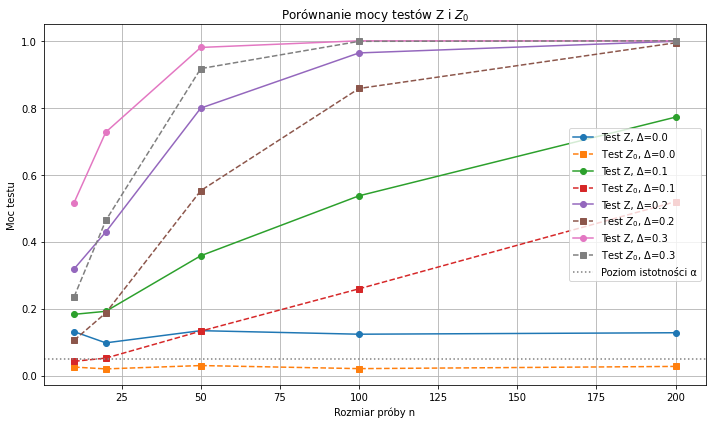

In [16]:
n_values = [10, 20, 50, 100, 200]
delta_values = [0.0, 0.1, 0.2, 0.3]
alpha = 0.05
n_sim = 5000

results_Z = {}
results_Z0 = {}

for delta in delta_values:
    power_Z = []
    power_Z0 = []
    for n in tqdm(n_values, desc=f"Delta = {delta}"):
        p12 = 0.25 + delta / 2
        p21 = 0.25 - delta / 2

        reject_Z = 0
        reject_Z0 = 0

        for _ in range(n_sim):
            y12 = np.random.binomial(n, p12)
            y21 = np.random.binomial(n, p21)

            if test_Z(y12, y21, n) < alpha:
                reject_Z += 1
            if test_Z0(y12, y21, n) < alpha:
                reject_Z0 += 1

        power_Z.append(reject_Z / n_sim)
        power_Z0.append(reject_Z0 / n_sim)

    results_Z[delta] = power_Z
    results_Z0[delta] = power_Z0

plt.figure(figsize=(10, 6))
for delta in delta_values:
    plt.plot(n_values, results_Z[delta], marker='o', label=f"Test Z, Δ={delta}")
    plt.plot(n_values, results_Z0[delta], marker='s', linestyle='--', label=f"Test $Z_0$, Δ={delta}")

plt.axhline(alpha, color='gray', linestyle=':', label="Poziom istotności α")
plt.title("Porównanie mocy testów Z i $Z_0$")
plt.xlabel("Rozmiar próby n")
plt.ylabel("Moc testu")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test $Z$ okazuje się bardziej efektywny niż $Z_0 $, szczególnie przy mniejszych próbach i słabszych efektach (niewielkie $\Delta\$). Rekomenduje się jego stosowanie tam, gdzie ważna jest maksymalizacja mocy testu i dokładność, a nie tylko uproszczenie obliczeń.


### ZADANIE 4
    Dla danych dołączonych do pierwszej listy zadań, na podstawie zmiennych CZY_ZADW oraz CZY_ZADW_2, zweryfikuj hipotezę, że zadowolenie ze szkoleń w pierwszym badanym okresie i w drugim badanym okresie pierwszego badania odpowiada modelowi symetrii. Czy na podstawie uzyskanych wników możemy wnioskować, że poziom zadowolenia ze szkoleń nie uległ zmianie? Przyjmij poziom istotności 0.05.

In [26]:
table = pd.crosstab(data["CZY_ZADOW"], data["CZY_ZADOW_2"])

b = table.loc['TAK', 'NIE'] if ('TAK' in table.index and 'NIE' in table.columns) else 0
c = table.loc['NIE', 'TAK'] if ('NIE' in table.index and 'TAK' in table.columns) else 0

chi2_stat = ((abs(b - c) - 1) ** 2) / (b + c)
p_mcnemar = 1 - chi2.cdf(chi2_stat, df=1)

print("Test McNemara:")
print("P-wartość:", p_mcnemar)

Test McNemara:
P-wartość: 0.03763531378731433


Na podstawie przeprowadzonego testu McNemara uzyskano wartość $ p = 0.0376 $, która jest mniejsza niż przyjęty poziom istotności $\alpha = 0.05$. Oznacza to, że istnieją statystycznie istotne różnice między poziomem zadowolenia ze szkoleń w pierwszym i drugim badanym okresie. Odrzucamy hipotezę symetrii – poziom zadowolenia ze szkoleń uległ zmianie między badanymi okresami.

### ZADANIE 5
    W firmie, o której mowa w zadaniu 1 z listy 1, wdrożono pewne działania w celu poprawy komfortu pracy. Następnie badaną grupę respondentów ponownie poproszono o odpowiedź na pytanie dotyczące oceny podejścia firmy do umożliwiania wdrażania wiedzy zdobytej na szkoleniach. W Tabeli 2 przedstawiono tablicę dwudzielczą uwzględniającą odpowiedzi na pytanie w obu tych okresach. Na podstawie danych zweryfikuj hipotezę, że odpowiedzi w pierwszym badanym okresie i w drugim okresie odpowiadają modelowi symetrii. Na podstawie wyników uzyskanych przy weryfikacji hipotezy dotyczącej symetrii, sformułuj wniosek dotyczący hipotezy, że ocena podejścia firmy nie uległa zmianie.

<div align="center">

<table>
  <thead>
    <tr>
      <th rowspan="2">Pytanie 1</th>
      <th colspan="5">Pytanie 2</th>
    </tr>
    <tr>
      <th>-2</th>
      <th>-1</th>
      <th>0</th>
      <th>1</th>
      <th>2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>-2</strong></td>
      <td>10</td>
      <td>2</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td><strong>-1</strong></td>
      <td>0</td>
      <td>15</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td><strong>0</strong></td>
      <td>1</td>
      <td>1</td>
      <td>32</td>
      <td>6</td>
      <td>0</td>
    </tr>
    <tr>
      <td><strong>1</strong></td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>96</td>
      <td>3</td>
    </tr>
    <tr>
      <td><strong>2</strong></td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>26</td>
    </tr>
  </tbody>
</table>

<br>
Table 1: Dane do zadania 5.

Do oceny, czy rozkład odpowiedzi w dwóch różnych okresach badania jest symetryczny, wykorzystano **test ilorazu wiarygodności (G-test)**.

In [6]:
def likelihood_ratio_symmetry_test(matrix):
    """
    Test ilorazu wiarygodności (G-test) dla macierzy symetryczności.

    Parameters:
    matrix (np.array): kwadratowa tablica 2D z danymi liczbowymi

    Returns:
    tuple: (statystyka G, stopnie swobody, p-wartość)
    """
    g_stat = 0
    n = matrix.shape[0]
    for i in range(n):
        for j in range(i + 1, n):
            nij = matrix[i, j]
            nji = matrix[j, i]
            if nij + nji > 0:
                m = (nij + nji) / 2
                if nij > 0:
                    g_stat += 2 * nij * np.log(nij / m)
                if nji > 0:
                    g_stat += 2 * nji * np.log(nji / m)
    df = (n * (n - 1)) // 2
    p_value = 1 - chi2.cdf(g_stat, df)
    return g_stat, df, p_value

Statystyka testowa w teście ilorazu wiarygodności (nazywana też statystyką G) obliczana jest według wzoru:

$
G = 2 \sum_{i<j} \left[ n_{ij} \cdot \ln\left(\frac{n_{ij}}{m_{ij}}\right) + n_{ji} \cdot \ln\left(\frac{n_{ji}}{m_{ji}}\right) \right]
$

Gdzie:
- $ n_{ij} $ i $ n_{ji} $ — liczby odpowiedzi w komórkach niesymetrycznych (poniżej i powyżej przekątnej),
- $ m_{ij} = m_{ji} = \frac{n_{ij} + n_{ji}}{2} $ — liczby oczekiwane pod hipotezą symetrii.

Test porównuje więc rozkład obserwowany z rozkładem teoretycznym, w którym zakłada się, że liczba odpowiedzi w parach symetrycznych powinna być taka sama.

In [7]:
data_matrix = np.array([
    [10, 2, 1, 1, 0],
    [0, 15, 1, 1, 0],
    [1, 1, 32, 6, 0],
    [0, 0, 1, 96, 3],
    [1, 1, 0, 1, 26]
])

g_stat, df, p_value = likelihood_ratio_symmetry_test(data_matrix)

print("Test ilorazu wiarygodności (G-test) dla symetrii:")
print(f"Statystyka G: {g_stat:.4f}")
print(f"Stopnie swobody: {df}")
print(f"P-wartość: {p_value:.4f}")

Test ilorazu wiarygodności (G-test) dla symetrii:
Statystyka G: 13.3267
Stopnie swobody: 10
P-wartość: 0.2060


Nie stwierdzono istotnych statystycznie różnic w ocenach podejścia firmy do umożliwiania wdrażania wiedzy zdobytej na szkoleniach pomiędzy dwoma badanymi okresami. Oznacza to, że na podstawie dostępnych danych nie można uznać, że ocena tego podejścia uległa zmianie.

## CZĘŚĆ III

### ZADANIE 6
    W pewnym badaniu porównywano skuteczność dwóch metod leczenia: Leczenie A to nowa procedura, a Leczenie B to stara procedura. Przeanalizuj dane przedstawione w Tabeli 3 (wyniki dla całej grupy pacjentów) oraz w Tabelach 4 i 5 (wyniki w podgrupach ze względu na dodatkową zmienną) i odpowiedz na pytanie, czy dla danych występuje paradoks Simpsona.

<div align="center">

<table>
  <thead>
    <tr>
      <th rowspan="2">Metoda</th>
      <th colspan="2">Wynik leczenia</th>
    </tr>
    <tr>
      <th>Poprawa</th>
      <th>Brak</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Leczenie A</strong></td>
      <td>117</td>
      <td>104</td>
    </tr>
    <tr>
      <td><strong>Leczenie B</strong></td>
      <td>177</td>
      <td>44</td>
    </tr>
  </tbody>
</table>
<br>
Table 3: Dane dla całej grupy

$\quad$

<table>
  <thead>
    <tr>
      <th rowspan="2">Metoda</th>
      <th colspan="2">Wynik leczenia</th>
    </tr>
    <tr>
      <th>Poprawa</th>
      <th>Brak</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Leczenie A</strong></td>
      <td>17</td>
      <td>101</td>
    </tr>
    <tr>
      <td><strong>Leczenie B</strong></td>
      <td>2</td>
      <td>36</td>
    </tr>
  </tbody>
</table>
<br>
Table 4: Dane dla pacjentów z chorobami współistniejącymi


$\quad$
<table>
  <thead>
    <tr>
      <th rowspan="2">Metoda</th>
      <th colspan="2">Wynik leczenia</th>
    </tr>
    <tr>
      <th>Poprawa</th>
      <th>Brak</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Leczenie A</strong></td>
      <td>100</td>
      <td>3</td>
    </tr>
    <tr>
      <td><strong>Leczenie B</strong></td>
      <td>175</td>
      <td>8</td>
    </tr>
  </tbody>
</table>

<br>
Table 5: Dane dla pacjentów bez chorób współistniejących

$\textbf{PARADOKS SIMPSONA}$

Zjawisko statystyczne, w którym trend obecny w kilku grupach może zniknąć lub odwrócić się po połączeniu danych w jedną analizę. Oznacza to, że związek między zmiennymi w całej populacji może być odwrotny niż w każdej z podgrup tej populacji.

W analizowanym badaniu porównano skuteczność dwóch metod leczenia:

- Leczenie A – nowa procedura,

- Leczenie B – dotychczas stosowana metoda.

Dane zostały podzielone na dwie podgrupy: pacjentów z chorobami współistniejącymi (Tabela 4) i pacjentów bez chorób współistniejących (Tabela 5).

In [ ]:
tab3_dataA = {"improvement": 117, "no_improvement": 104}
tab3_dataB = {"improvement": 177, "no_improvement": 44}

tab4_dataA = {"improvement": 17, "no_improvement": 101}
tab4_dataB = {"improvement": 2, "no_improvement": 36}

tab5_dataA = {"improvement": 100, "no_improvement": 3}
tab5_dataB = {"improvement": 175, "no_improvement": 8}

Po obliczeniu odsetka pacjentów, u których nastąpiła poprawa w każdej podgrupie, uzyskano następujące wyniki:

In [ ]:
def effectiveness_percent(data):
    improvement, no_improvement = data["improvement"], data["no_improvement"]
    return improvement/(improvement+no_improvement) * 100

In [ ]:
# tabela 3
eff_tab3_A = effectiveness_percent(tab3_dataA)
eff_tab3_B = effectiveness_percent(tab3_dataB)

# tabela 4
eff_tab4_A = effectiveness_percent(tab4_dataA)
eff_tab4_B = effectiveness_percent(tab4_dataB)

# tabela 5
eff_tab5_A = effectiveness_percent(tab5_dataA)
eff_tab5_B = effectiveness_percent(tab5_dataB)

In [ ]:
df_eff = pd.DataFrame({
    "Tabela 3 (Ogółem) %": [eff_tab3_A, eff_tab3_B],
    "Tabela 4 (Z chorobami) %": [eff_tab4_A, eff_tab4_B],
    "Tabela 5 (Bez chorób) %": [eff_tab5_A, eff_tab5_B],
}, index=["Leczenie A", "Leczenie B"])

print("Tabela: Skuteczność metody leczenia (%)")
round(df_eff, 2)

Tabela: Skuteczność metody leczenia (%)


,Tabela 3 (Ogółem) %,Tabela 4 (Z chorobami) %,Tabela 5 (Bez chorób) %
Leczenie A,52.94,14.41,97.09
Leczenie B,80.09,5.26,95.63


Analiza wykazuje, że w obu podgrupach leczenie A było skuteczniejsze – wśród pacjentów z chorobami współistniejącymi o 9.15%, a wśród pacjentów bez chorób – o 1.46%. Jednak po połączeniu danych, to leczenie B okazuje się skuteczniejsze (o 27.15%).

Taka rozbieżność prowadzi do wniosku, iż istotnie mamy tu do czynienia z przykładem Paradoksu Simpsona. Dzieje się tak, ponieważ leczenie A częściej stosowano u pacjentów trudniejszych (z chorobami), a leczenie B – u pacjentów łatwiejszych (bez chorób). Nierówny rozkład pacjentów pomiędzy grupami zafałszował wynik zbiorczy, dając być może mylne wrażenie przewagi leczenia B.

### ZADANIE 7
    Dla danych z listy 1, przyjmując za zmienną 1 zmienną CZY_KIER, za zmienną 2– zmienną PYT_2 i za zmienną 3– zmienną STAŻ, podaj interpretacje nastepujacych modeli log-liniowych: [1 3], [13], [1 2 3], [12 3], [12 13] oraz [1 23].

W tym zadaniu przyjmujemy następujące oznaczenia zmiennych:

- 1 – CZY_KIER (czy osoba zajmuje stanowisko kierownicze),

- 2 – PYT_2 (odpowiedź na pytanie 2),

- 3 – STAŻ (staż pracy).

Dodatkowo zakładamy, że zmienna CZY_KIER ma $R$ możliwych odpowiedzi, zmienna PYT_2 - $C$ możliwych odpowiedzi, a zmienna STAŻ - $L$ możliwych odpowiedzi (w tym przypadku: $R=2$, $C=4$, $L=3$).

Wówczas interpretacje modeli log-liniowych przedstawiają się następująco:

a) Model $[1 \quad 3]$

Zmienne 1 i 3 są niezależne. Model można zapisać w postaci:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_k^{(3)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że zmienne CZY_KIER i STAŻ nie są ze sobą powiązane — innymi słowy, zajmowanie stanowiska kierowniczego nie zależy od stażu pracy.

b) Model $[13]$

Zmienn3 1 i 3 nie są niezależne. Model ma postać:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_k^{(3)} + \lambda_{ik}^{(13)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że występuje zależność między zmienną CZY_KIER a STAŻ — czyli zajmowanie stanowiska kierowniczego może być związane ze stażem pracy.

c) Model $[1 \quad 2 \quad 3]$

Wszystkie trzy zmienne 1, 2 i 3 są wzajemnie niezależne. Model zapisujemy jako:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że nie występują żadne interakcje między zmiennymi. Zmienna CZY_KIER jest niezależna zarówno od PYT_2, jak i STAŻU, a PYT_2 i STAŻ również nie są ze sobą powiązane.

d) Model $[12 \quad 3]$

Zmienna 3 jest niezależna od zmiennych 1 i 2, ale między zmiennymi 1 i 2 istnieje zależność. Model zapisujemy jako:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)} + \lambda_{ij}^{(12)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że występuje zależność pomiędzy zmiennymi CZY_KIER i PYT_2, natomiast STAŻ nie wpływa na żadne z pozostałych dwóch zmiennych i jest od nich niezależny.

e) Model $[12 \quad 13]$

Występuje zależność między 1 i 2, oraz 1 i 3, jednak zmienne 2 i 3 są od siebie niezależne. Model zapisujemy jako:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)} + \lambda_{ij}^{(12)} + \lambda_{ik}^{(13)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że zmienna CZY_KIER jest powiązana zarówno z PYT_2, jak i ze STAŻEM, natomiast PYT_2 i STAŻ pozostają niezależne od siebie.

f) Model $[1 \quad 23]$

Zmienna 1 jest niezależna od zmiennych 2 i 3, natomiast pomiędzy zmiennymi 2 i 3 istnieje zależność. Model zapisujemy jako:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)} + \lambda_{jk}^{(23)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że odpowiedzi na PYT_2 są powiązane ze STAŻEM, natomiast zmienna CZY_KIER nie jest związana z żadną z pozostałych zmiennych.

## CZĘŚĆ IV i V

### ZADANIE 8
    Przyjmując model log-liniowy [123] dla zmiennych opisanych w zadaniu 7 oszacuj prawdopobiebieństwa:
        a) że osoba pracująca na stanowisku kierowniczym jest zdecydowanie zadowolona ze szkoleń;
        b) że osoba o stażu pracy krótszym niż rok pracuje na stanowisku kierowniczym;
        c) że osoba o stażu pracy powyżej trzech lat nie pracuje na stanowisku kierowniczym.
    Jakie byłyby oszacowania powyższych prawdopodobieństw przy założeniu modelu [12 23]?

Przyjmujemy model $[123]$, tzn. zakładamy, że istnieje zależność między każdą ze zmiennych 1, 2 i 3. Innymi słowy - między odpowiedzią na PYT_2, zajmowanym stanowiskiem a stażem pracy występują złożone zależności — każda z tych zmiennych wpływa na pozostałe, a ich powiązania nie ograniczają się jedynie do par, lecz obejmują również wspólne oddziaływanie trójczynnikowe.

Model można zapisać w postaci: 

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)} + \lambda_{ijk}^{(123)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\},$$

gdzie w tym przypadku: $R=2$, $C=4$, $L=3$.


a) prawdopodobieństwo, że osoba pracująca na stanowisku kierowniczym jest zdecydowanie zadowolona ze szkoleń

### ZADANIE 9
    Dla danych wskazanych w zadaniu 7 zweryfikuj następujące hipotezy:
        a) zmienne losowe CZY_KIER, PYT_2 i STAŻ są wzajemnie niezależne;
        b) zmienna losowa PYT_2 jest niezależna od pary zmiennych CZY_KIER i STAŻ;
        c)  zmienna losowa PYT_2 jest niezależna od zmiennej CZY_KIER, przy ustalonej wartości zmiennej STAŻ.

--------------------------------------------------

## ZADANIA DODATKOWE

### ZADANIE *1
    W przypadku zadania 5 występuje problem z zastosowaniem testu Bowkera ze względu na występowanie zer na określonych miejscach w tabeli z danymi. Zastosuj w tym przypadku dokładny test symetrii i opisz w jaki sposób wyznaczana jest wartość poziomu krytycznego w tym teście.

### ZADANIE *2
    Na podstawie danych z listy 1 dokonaj wyboru modelu rozważając uwzględnienie zmiennych PYT_1, PYT_2 i PŁEĆ w oparciu o:
        a) testy
        b) kryterium AIC
        c) kryterium BIC